Workbook

First step is to load in the data into separate pandas dataframes

In [20]:
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt


total_gdp = pd.read_csv("total_gdp_us_inflation_adjusted.csv")
total_gdp = total_gdp.set_index('country')

gdp_percap = pd.read_csv("gdppercapita_us_inflation_adjusted.csv")
gdp_percap = gdp_percap.set_index('country')
gini = pd.read_csv("gini.csv")
gini = gini.set_index('country')

Convert values in each df from string to float, parsing special characters as needed. E.g., '400B' is 400.0e9.

In [29]:
total_gdp_copy = total_gdp.copy()
gdp_percap_copy = gdp_percap.copy()
    

for country in total_gdp_copy.index:
    for year in total_gdp_copy:
        val = total_gdp_copy.loc[country][year]
        if isinstance(val, float):
            continue    
        val = val.strip().upper()
        if val.endswith('K'):
            total_gdp_copy.loc[country,year] = float(val[:-1]) * 1e3
        elif val.endswith('M'):
            total_gdp_copy.loc[country,year] = float(val[:-1]) * 1e6
        elif val.endswith('B'):
            total_gdp_copy.loc[country,year] = float(val[:-1]) * 1e9
        elif val.endswith('TR'):
            total_gdp_copy.loc[country,year] = float(val[:-2]) * 1e12
        else:
            total_gdp_copy.loc[country,year] = float(val[:-1])

for country in gdp_percap_copy.index:
    for year in gdp_percap_copy:
        val = gdp_percap_copy.loc[country][year]
        if isinstance(val, float):
            continue    
        val = val.strip().upper()
        if val.endswith('K'):
            gdp_percap_copy.loc[country][year] = float(val[:-1]) * 1e3
        elif val.endswith('M'):
            gdp_percap_copy.loc[country][year] = float(val[:-1]) * 1e6
        elif val.endswith('B'):
            gdp_percap_copy.loc[country][year] = float(val[:-1]) * 1e9
        elif val.endswith('TR'):
            gdp_percap_copy.loc[country][year] = float(val[:-2]) * 1e12
        else:
            gdp_percap_copy.loc[country][year] = float(val[:-1])
del country
del year
del val



Raw data loaded in as pandas dataframes. Now need to merge across a new axis called 'Metric'. Outer index is 'Metric', inner index is 'Country'. Use inner join to only include years common to all dataframes.

In [22]:
mask_total_gdp     = total_gdp_copy.index.isin(gdp_percap_copy.index) & total_gdp_copy.index.isin(gini.index)
mask_gdp_percap    = gdp_percap_copy.index.isin(total_gdp_copy.index) & gdp_percap_copy.index.isin(gini.index)
mask_gini          = gini.index.isin(total_gdp_copy.index) & gini.index.isin(gdp_percap_copy.index)

total_gdp_filtered     = total_gdp_copy[mask_total_gdp]
gdp_percap_filtered    = gdp_percap_copy[mask_gdp_percap]
gini_filtered          = gini[mask_gini]

In [23]:
combined_data = pd.concat([total_gdp_filtered, gdp_percap_filtered, gini_filtered], axis=0, keys=['Total GDP', 'GDP Per Capita', 'Gini Coeff'], join='inner')
combined_data.index.names = ['Metric', 'Country']
# new_gini = combined_data.loc['Gini Coeff']
# Canada = combined_data.xs('Canada', level='Country')
# Canada_GDP_2023 = combined_data.xs('Total GDP', level='Metric').loc['Canada', '2023']
# combined_data.shape
# totalGDP_Gini_diff = total_gdp_copy.index.difference(gini.index)
# Gini_totalGDP_diff = gini.index.difference(total_gdp.index)
# GDPpercap_Gini_diff = gdp_percap_copy.index.difference(gini.index)

# all_rejected_countries = list(totalGDP_Gini_diff) + list(Gini_totalGDP_diff)
# print(all_rejected_countries)
del mask_total_gdp
del mask_gdp_percap
del mask_gini

del total_gdp_filtered
del gdp_percap_filtered
del gini_filtered       


In [ ]:
# Canada = combined_data.xs('Canada', level='Country')
# Canada_GDP_2023 = combined_data.xs('Total GDP', level='Metric').loc['Canada', '2023']

Now, remove rows (countries) that do not meet the threshold for sufficient valid data. For now, lets say we need a minimum of half of the years having a value.

In [24]:
combined_data_copy = combined_data.copy()
combined_data_copy.sort_index





<bound method DataFrame.sort_index of                          1960  1961  1962  1963  1964  1965  1966  1967  1968  \
Metric     Country                                                              
Total GDP  Afghanistan    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
           Angola         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
           Albania        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
           Andorra        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
           UAE            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...                       ...   ...   ...   ...   ...   ...   ...   ...   ...   
Gini Coeff Samoa         40.7  40.7  40.7  40.7  40.7  40.7  40.7  40.7  40.7   
           Yemen         37.3  37.3  37.3  37.3  37.3  37.3  37.3  37.3  37.3   
           South Africa  66.0  66.9  67.5  67.9  68.0  68.1  68.2  68.4  68.5   
           Zambia        64.3  65.0  65.5  65.9  66.1  66.3  66.3  66.4

In [25]:
years_list = combined_data_copy.columns.tolist()
valid_country_list = combined_data.index.get_level_values('Country').unique().tolist()

In [26]:
# Canada = combined_data.xs('Canada', level='Country').drop()
# canada_gdp = pd.isna(Canada.loc['Total GDP'].values).sum()
# UAE = combined_data.xs('UAE', level='Country')
# UAE_gdp = pd.isna(UAE.loc['Total GDP'].values).sum()

for country in valid_country_list:
    country_slice = combined_data.xs(country, level='Country')
    country_gdp_nan_sum = pd.isna(country_slice.loc['Total GDP'].values).sum()
    country_gdp_percap_nan_sum = pd.isna(country_slice.loc['GDP Per Capita'].values).sum()
    if (country_gdp_nan_sum > len(years_list)/2) | (country_gdp_percap_nan_sum > len(years_list)/2):
        combined_data_copy = combined_data_copy.drop(country, level='Country')
        print("Dropping", country, " - ", country_gdp_nan_sum, "missing values in Total GDP.")
        print(country_gdp_percap_nan_sum, "missing values in GDP Per Capita.")

Dropping Afghanistan  -  40 missing values in Total GDP.
40 missing values in GDP Per Capita.
Dropping Djibouti  -  53 missing values in Total GDP.
53 missing values in GDP Per Capita.
Dropping Eritrea  -  44 missing values in Total GDP.
44 missing values in GDP Per Capita.
Dropping Liechtenstein  -  63 missing values in Total GDP.
63 missing values in GDP Per Capita.
Dropping Montenegro  -  37 missing values in Total GDP.
37 missing values in GDP Per Capita.
Dropping Palestine  -  34 missing values in Total GDP.
34 missing values in GDP Per Capita.
Dropping San Marino  -  38 missing values in Total GDP.
38 missing values in GDP Per Capita.
Dropping Serbia  -  35 missing values in Total GDP.
35 missing values in GDP Per Capita.
Dropping South Sudan  -  56 missing values in Total GDP.
56 missing values in GDP Per Capita.
Dropping Yemen  -  35 missing values in Total GDP.
30 missing values in GDP Per Capita.


In [27]:
valid_country_list = combined_data_copy.index.get_level_values('Country').unique().tolist()
combined_data_copy.index.names[0] == 'Metric'

True

Tasks going forward:
- User Entry (COMPLETED)
    - Prompt user to enter some number of countries, and a start year and end year.
    - Returns a tuple of ([list of Strings as country names], [list of start year, end year]).

- Dataframe cleaning: (COMPLETED)
    Remove countries that have less that length/2 valid numbers.

- Plotting:
    - Plot for each metric containing:
        - all contries and global average for time slice. 

- Presentation:
    - Summary of problem statement
    - Summary of data processing steps taken
    - Figures
    - Formatting into .pptx


/Users/williamwatson/anaconda3/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/williamwatson/anaconda3/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


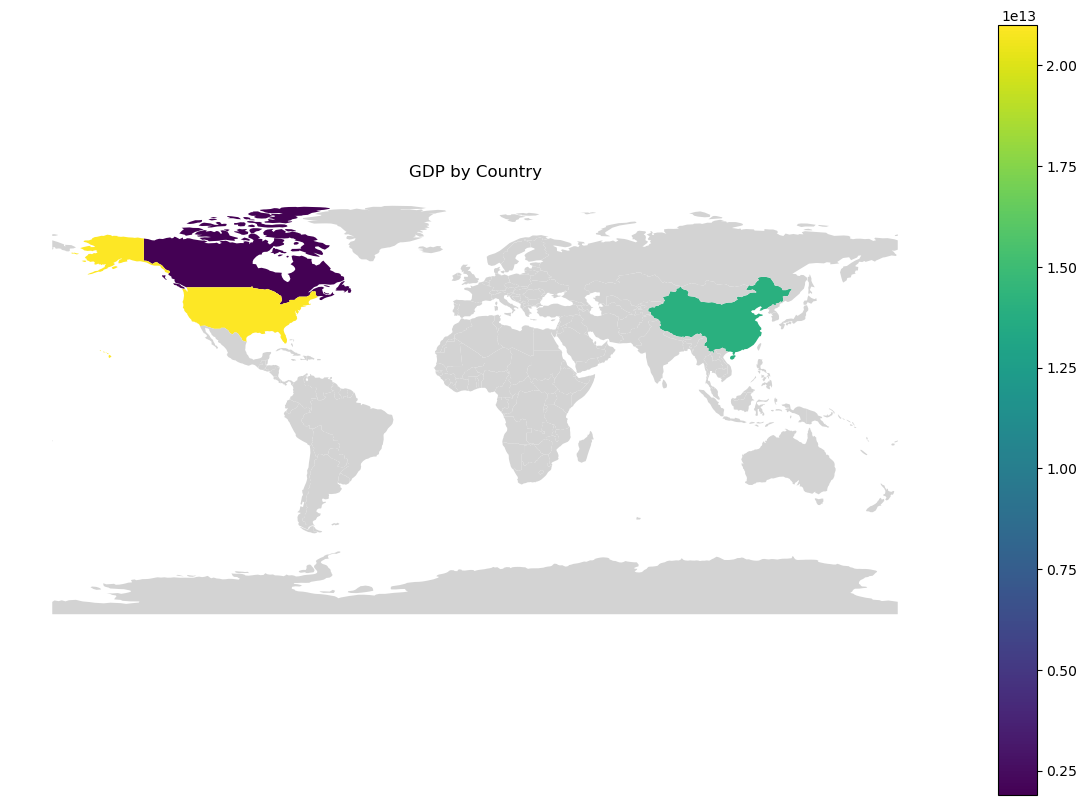

In [28]:
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))


gdp_data_test = pd.DataFrame({
    'country': ['United States of America', 'Canada', 'China'],
    'GDP': [21e12, 1.9e12, 14e12]
})

# Merge GDP data with world map
world_gdp = world.merge(gdp_data_test, how='left', left_on='name', right_on='country')

# Plot
world_gdp.plot(column='GDP', cmap='viridis', legend=True, figsize=(15, 10), missing_kwds={"color": "lightgrey"})
plt.title('GDP by Country')
plt.axis('off')
plt.show()




In [ ]:
print(world)

For new columns to add, average YoY % increase in GDP for each country.

"Gini Dollars" GDP Per Cap * (1 - Gini coeff)